
# Content

Following code discusses:

    -Data cleaning and proocessing
    -Majority class baseline more

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from time import time
import re

from helper import preprocessor as pp
from helper import precisionmeasures as pm

from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import precision_recall_fscore_support as prfs
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
font = {'family' : 'sans-serif',
        'style' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = 12, 8

In [40]:
tweet_cat = ['Hate','Offensive','Neutral']
data = pp.load_data('labeled_data.csv')
max_length = 140
data['clean_tweet'] = data.tweet.apply(lambda doc: pp.clean_doc(doc))
data.head()


,labels,category,tweet,clean_tweet
0,2,neutral,!!! RT @mayasolovely: As a woman you shouldn't...,woman shouldnt complain cleaning house man alw...
1,1,offensive,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dats coldtyga dwn bad cuffin dat hoe place
2,1,offensive,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg ever fuck bitch start cry confused shit
3,1,offensive,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,look like tranny
4,1,offensive,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shit hear might true might faker bitch told ya


In [44]:

K[0]

1430

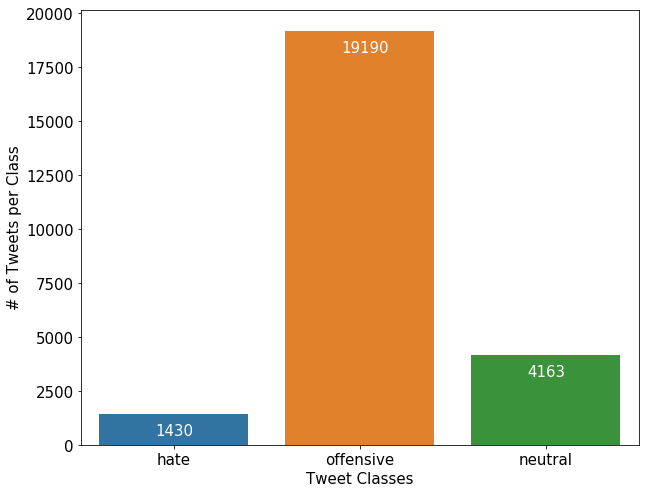

In [51]:
plt.figure(figsize = (10,8))
sns.countplot(data.labels)
plt.xticks([0,1,2],['hate','offensive','neutral'])
plt.xlabel('Tweet Classes')
plt.ylabel('# of Tweets per Class')
temp_df  = data.labels.value_counts().sort_index()
for i in range(3):
    plt.text(i-0.1,temp_df[i]-1000,temp_df[i], color = 'white')

In [31]:
data['length'] = data.clean_tweet.apply(lambda t: len(t.split()))
data['raw_len'] = data.tweet.apply(lambda t: len(t))
data['clean_len'] = data.clean_tweet.apply(lambda t: len(t))

In [5]:
data_stat = data[['raw_len','clean_len']].describe()
data_stat.columns = ['raw tweet length','clean tweet length']
(np.round(data_stat.T,2))
class_names = ['Hate','Offensive','Neutral']

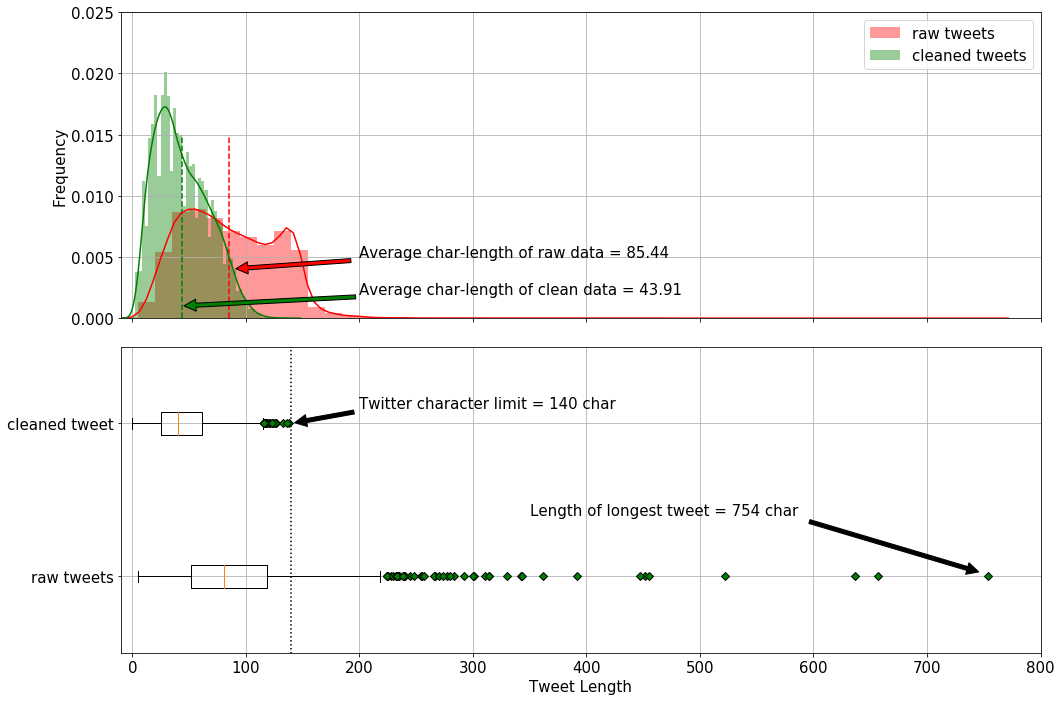

In [6]:
fig = plt.figure(figsize = (15,10))

ax2 = fig.add_subplot(211)
sns.distplot(data.raw_len,color = 'red', label = 'raw tweets', ax = ax2)
sns.distplot(data.clean_len,color = 'green',label = 'cleaned tweets', ax = ax2)

plt.legend(loc = 'upper right', fontsize = 15)

ax2.vlines(np.mean(data.raw_len),0,0.015,linestyle = "--",color = 'red')
ax2.vlines(np.mean(data.clean_len),0,0.015,linestyle = "--",color = 'green')

ax2.annotate('Average char-length of raw data = {}'.format(np.round(np.mean(data.raw_len),2)),
            xy=(np.mean(data.raw_len),0.004), xytext=(200,0.005),
            arrowprops=dict(facecolor='red', shrink=0.05), fontsize = 15);

ax2.annotate('Average char-length of clean data = {}'.format(np.round(np.mean(data.clean_len),2)),
            xy=(np.mean(data.clean_len),0.001), xytext=(200,0.002),
            arrowprops=dict(facecolor='green', shrink=0.01), fontsize = 15);
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.axis([-10, 800, 0, 0.025])
ax2.set_xlabel('')
ax2.set_ylabel('Frequency', size = 15)
ax2.set_xticklabels('')
plt.grid()

##################################################

ax1 = fig.add_subplot(212)
green_diamond = dict(markerfacecolor='g', marker='D')

ax1.boxplot([data.raw_len,data.clean_len],flierprops=green_diamond, vert=False);
ax1.vlines(140,0,3,linestyle = ':')
ax1.annotate(r'Length of longest tweet = {} char'.format(max(data.raw_len)),
            xy=(max(data.raw_len),1.01), xytext=(350,1.4),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize = 15)
ax1.annotate('Twitter character limit = 140 char', xy=(140,2), xytext=(200,2.1),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize = 15)
ax1.set_yticklabels(['raw tweets','cleaned tweet'])
ax1.set_xticks(np.arange(0,900,100))
ax1.set_xticklabels(np.arange(0,900,100))
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_xlabel('Tweet Length', size = 15);
ax1.axis([-10, 800, 0.5, 2.5])
plt.grid()
plt.tight_layout()

In [7]:
# Split the dataset into training and test sets
train_data, test_data = data[:20000], data[20000:]

In [8]:
train_cnt = train_data.groupby('labels').count().category
test_cnt = test_data.groupby('labels').count().category

In [9]:
df_cnt = pd.concat([train_cnt,test_cnt],axis = 1)
df_cnt.columns = ['Training_set','Test_set']
df_cnt = df_cnt.T
df_cnt.columns = tweet_cat

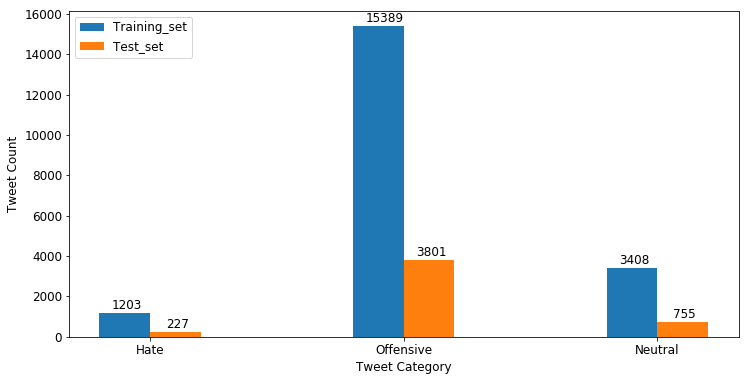

In [10]:
plt.figure(figsize=(12,6))
plt.hist([train_data.labels, test_data.labels], bins = 5)
legend_lab = ['Training_set','Test_set']
plt.legend(legend_lab,fontsize = 12, bbox_to_anchor=(0.0, 0.5, 0.5, 0.5))
plt.xticks([0.2,1.0,1.8],tweet_cat,size = '12')
plt.yticks(size = '12')
plt.xlabel('Tweet Category', size = '12')
plt.ylabel('Tweet Count', size = '12')

plt.text(0.08,df_cnt.iloc[0,0]+200,'{}'.format(df_cnt.iloc[0,0]),size ='12')
plt.text(0.25,df_cnt.iloc[1,0]+200,'{}'.format(df_cnt.iloc[1,0]),size ='12')

plt.text(0.88,df_cnt.iloc[0,1]+200,'{}'.format(df_cnt.iloc[0,1]),size ='12')
plt.text(1.04,df_cnt.iloc[1,1]+200,'{}'.format(df_cnt.iloc[1,1]),size ='12')

plt.text(1.68,df_cnt.iloc[0,2]+200,'{}'.format(df_cnt.iloc[0,2]),size ='12')
plt.text(1.85,df_cnt.iloc[1,2]+200,'{}'.format(df_cnt.iloc[1,2]),size ='12')

plt.show()

In [11]:
# Split the test and training data into label and feature sets
x_train,y_train = train_data.clean_tweet,train_data.labels
x_test,y_test = test_data.clean_tweet,test_data.labels

# Word-Length Analysis

Total vocab size: 18498


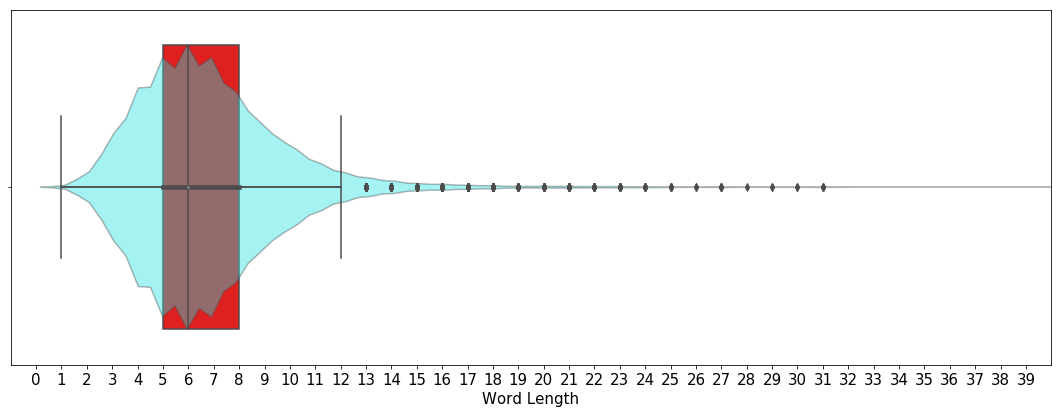

In [23]:
# tokenize each tweet in the training dataset
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
vocab_size = len(tokenizer.word_index)+1
print('Total vocab size: {}'.format(vocab_size))
word_list = []
# for each word in dictionary extract their lengths
for word,i in tokenizer.word_index.items():
    word_list.append(len(word))

fig,ax = plt.subplots(figsize = (15,6))

sns.violinplot(word_list,color = 'cyan', alpha = 0.2)
sns.boxplot(word_list,color = 'red')

ax.set(xticks = np.arange(0,40,1),
       xticklabels=np.arange(0,41,1),
       xlim = [-1,40],
       xlabel ='Word Length')

# aplha = 0.4 does not work in new version of seaborn: use collections
plt.setp(ax.collections, alpha=.4) 
plt.tight_layout()

In [25]:
data['word_count'] = data.clean_tweet.apply(lambda t: len(t.split()))
data.head()

,labels,category,tweet,clean_tweet,length,raw_len,clean_len,word_count
0,2,neutral,!!! RT @mayasolovely: As a woman you shouldn't...,woman shouldnt complain cleaning house man alw...,9,140,60,9
1,1,offensive,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dats coldtyga dwn bad cuffin dat hoe place,9,85,46,9
2,1,offensive,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg ever fuck bitch start cry confused shit,8,120,44,8
3,1,offensive,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,look like tranny,3,62,16,3
4,1,offensive,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shit hear might true might faker bitch told ya,9,137,46,9


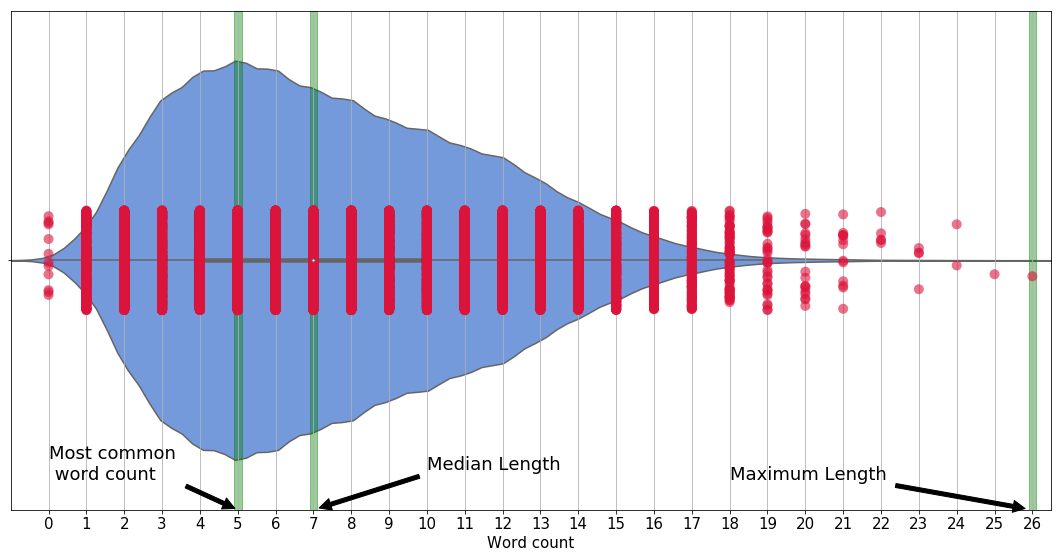

In [30]:
wc_median = np.median(data.word_count)
wc_most_common = np.argmax(data.word_count.value_counts())
wc_max = max(data.word_count)

fig,ax = plt.subplots(figsize = (15,8))

sns.stripplot(x=data["word_count"],size=10,marker="o",
              orient = 'h', jitter = 0.1,
              color = 'crimson',edgecolor="gray", alpha = 0.6)

sns.violinplot(x=data["word_count"],
               color = 'cornflowerblue')

ax.axvspan(wc_max-0.1, wc_max+0.1, ymin=0.0, ymax=1, alpha=0.4, color='green')
ax.axvspan(wc_most_common-0.1, wc_most_common+0.1, ymin=0.0, ymax=1, alpha=0.4, color='green')
ax.axvspan(wc_median-0.1, wc_median+0.1, ymin=0.0, ymax=1, alpha=0.4, color='green')

ax.annotate('Most common \n word count', xy=(wc_most_common,0.5), xytext=(0,0.44),
            arrowprops=dict(facecolor='black', shrink=0.05), size = 18)

ax.annotate('Median Length', xy=(wc_median,0.5), xytext=(10,0.42),
            arrowprops=dict(facecolor='black', shrink=0.05), size = 18)

ax.annotate('Maximum Length', xy=(wc_max,0.5), xytext=(18,0.44),
            arrowprops=dict(facecolor='black', shrink=0.05), size = 18)

ax.set(xticklabels = np.arange(0,36,1),
       xlim = [-1, wc_max+0.5],
       xticks = np.arange(0,36,1),
       xlabel = 'Word count')

ax.xaxis.grid() 

plt.tight_layout()

# MCB Model

In [13]:
y_pred_train = np.ones((len(y_train))) # Offensive text is labled as one
true_positives_train = sum(y_pred_train==y_train)
accuracy_train = true_positives_train/len(y_train)

print('Training accuracy of MCB : {:.2f}%'.format(accuracy_train*100))
print('=='*30)
y_pred_test = np.ones((len(y_test))) # Offensive text is labled as one
true_positives_test = sum(y_pred_test==y_test)
accuracy_test = true_positives_test/len(y_test)
print('=='*30)
print('Test accuracy of MCB : {:.2f}%'.format(accuracy_test*100))
print('=='*30)

Training accuracy of MCB : 76.94%
Test accuracy of MCB : 79.47%


## Performance Measures

In [14]:
print('=='*50)
tstp,tstr,tstf,_ = prfs(y_test, y_pred_test, average='micro')
print('For test dataset:')
print('--'*50)
print('micro-precision: {:.2f}, micro-recall: {:.2f}, micro-fscore: {:.2f}'.format(tstp,tstr,tstf))
tstp,tstr,tstf,_ = prfs(y_test, y_pred_test, average='macro')

print('--'*50)
print('macro-precision: {:.2f}, macro-recall: {:.2f}, macro-fscore: {:.2f}'.format(tstp,tstr,tstf))
print('=='*50)

For test dataset:
----------------------------------------------------------------------------------------------------
micro-precision: 0.79, micro-recall: 0.79, micro-fscore: 0.79
----------------------------------------------------------------------------------------------------
macro-precision: 0.26, macro-recall: 0.33, macro-fscore: 0.30


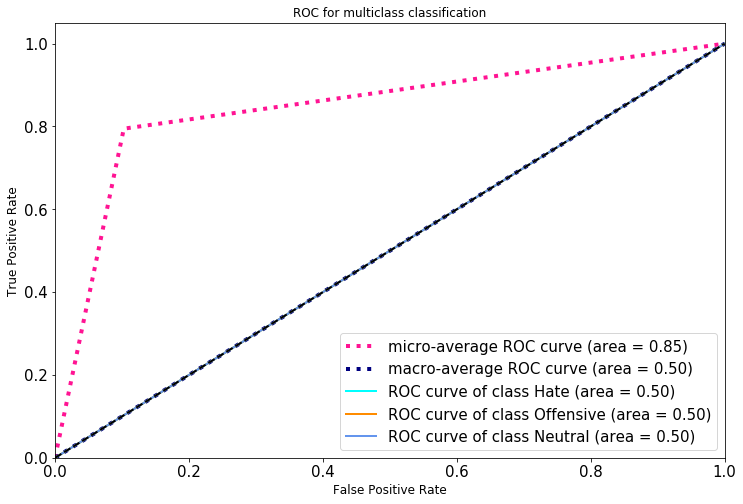

In [15]:
y_test_cat = to_categorical(y_test)
y_pred_cat = to_categorical(y_pred_test,num_classes = 3)
roc_auc = pm.ROC_curve(y_test_cat, y_pred_cat,3)

In [16]:
print('=='*30)
print('Classification Report')
print('--'*30)
print(classification_report(y_test, y_pred_test,target_names = tweet_cat))
print('=='*30)

Classification Report
------------------------------------------------------------
              precision    recall  f1-score   support

        Hate       0.00      0.00      0.00       227
   Offensive       0.79      1.00      0.89      3801
     Neutral       0.00      0.00      0.00       755

    accuracy                           0.79      4783
   macro avg       0.26      0.33      0.30      4783
weighted avg       0.63      0.79      0.70      4783



In [17]:
mcm = multilabel_confusion_matrix(y_test,y_pred_test)
temp_cm = np.zeros((6,6))
temp_cm[:2,:2] = mcm[0]
temp_cm[2:4,2:4] = mcm[1]
temp_cm[4:,4:] = mcm[2]

In [18]:
cm_labels = ['Not hate', 'Hate', 'Not offensive', 'Offensive', 'Not neutral', 'Neutral']

In [19]:
pd.DataFrame(temp_cm,index=cm_labels,columns = cm_labels)

,Not hate,Hate,Not offensive,Offensive,Not neutral,Neutral
Not hate,4556.0,0.0,0.0,0.0,0.0,0.0
Hate,227.0,0.0,0.0,0.0,0.0,0.0
Not offensive,0.0,0.0,0.0,982.0,0.0,0.0
Offensive,0.0,0.0,0.0,3801.0,0.0,0.0
Not neutral,0.0,0.0,0.0,0.0,4028.0,0.0
Neutral,0.0,0.0,0.0,0.0,755.0,0.0


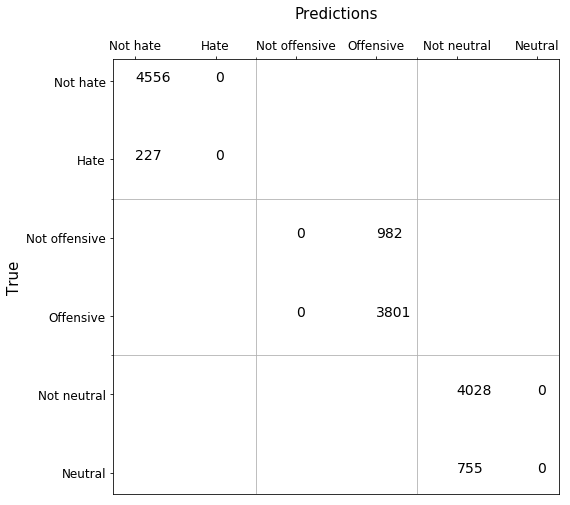

In [20]:
fig,ax = plt.subplots(figsize = (8,8))
ax.xaxis.tick_top()
ax.set_yticks([1.5, 3.5], minor=True)
ax.set_xticks([1.5, 3.5], minor=True)
ax.yaxis.grid(True, which='minor')
ax.xaxis.grid(True, which='minor')
ax.scatter(np.arange(6), np.arange(6),color = 'white')
for i in np.arange(0,6,2):
    for j in np.arange(i,i+2,1):
        plt.text(1+i,5-j,int(temp_cm[j,i+1]),size = '14')
        plt.text(0+i,5-j,int(temp_cm[j,i]),size = '14')
plt.xticks(np.arange(6),cm_labels, size = '12')
plt.yticks(np.arange(6),cm_labels[::-1], size = '12')
plt.title('Predictions\n\n', size = '15')
plt.ylabel('True', size = '15')

plt.show()

# Best Fit Model - Random Forest Classifier

The best fit model was selected based on the the word unigram inputs.
The following code takes longer time to run.

In [21]:
# Vectorizer = TfidfVectorizer()
# X_train_tfidf = Vectorizer.fit_transform(x_train)
# print("n_samples: %d, n_features: %d" % X_train_tfidf.shape)
# X_test_tfidf = Vectorizer.transform(x_test)
# print("n_samples: %d, n_features: %d" % X_test_tfidf.shape)

In [22]:
# Create the parameter grid based on the results of random search 

# param_grid_rf = {'max_features': [100,200,500],
#               'n_estimators': [500,800,1000]}


# clf = RandomForestClassifier()
# print('=' * 80)
# print(clf)

# grid_result = GridSearchCV(estimator = clf, param_grid = param_grid_rf, cv = 5, verbose = 2)
# grid_result.fit(X_train_tfidf,y_train)
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))
    
# score = grid_result.score(x_test, Y_test)
# print("Test score: {0:.2f} %".format(100 * score))
# predict = grid_result.predict(x_test)